## Initial Imports


In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
import torch

# import dependencies for PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mlc.data.mnist.dataset import MNIST
from mlc.data.celeba_align.dataset import CelebaAlign
from mlc.util.model import load_checkpoint
import mlc

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
torch.cuda.get_device_capability()

2.6.0+cu118
True
11.8
90100


(5, 0)

## Creating Model

In [3]:
import argparse
from mlc.model.vae.model import VAE

# Create parser and add arguments
parser = argparse.ArgumentParser()
VAE.add_arguments(parser)

# Parse empty args to use all defaults
args = parser.parse_args([])

# Convert Namespace to dict
args_dict = vars(args)

# Instantiate model with args
model = VAE(args_dict)
model

C-VAE: init_dim=24, layer_dim=24, num_blocks=3


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True,

In [4]:
from torchsummary import summary
print(summary(model,(3,256,256),device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 256, 256]             672
              ReLU-2         [-1, 24, 256, 256]               0
       BatchNorm2d-3         [-1, 24, 256, 256]              48
            Conv2d-4         [-1, 24, 128, 128]           5,208
            Conv2d-5         [-1, 24, 128, 128]           5,208
              ReLU-6         [-1, 24, 128, 128]               0
       BatchNorm2d-7         [-1, 24, 128, 128]              48
            Conv2d-8           [-1, 24, 64, 64]           5,208
            Conv2d-9           [-1, 24, 64, 64]           5,208
             ReLU-10           [-1, 24, 64, 64]               0
      BatchNorm2d-11           [-1, 24, 64, 64]              48
           Conv2d-12           [-1, 24, 32, 32]           5,208
           Conv2d-13           [-1, 24, 32, 32]           5,208
             ReLU-14           [-1, 24,

In [6]:
save_path = "../models/vae/20250530120602978545/latest/model_state.pt"
state_dict = torch.load(save_path)
#state_dict
model.load_state_dict(state_dict)

args_dict["z_mu_identity"] = {"value": True}  # Use identity for z_mu transform with pre-trained model
model_trained = VAE(args_dict)
save_path = "../models/vae/20250530202601774610/0040/model_state.pt"
state_dict = torch.load(save_path)
#state_dict
model_trained.load_state_dict(state_dict, strict=False)

C-VAE: init_dim=24, layer_dim=24, num_blocks=3


<All keys matched successfully>

## Importing dataset

In [8]:
%cd C:/Users/hss19/Documents/GitHub/ml-2025

C:\Users\hss19\Documents\GitHub\ml-2025


In [9]:
celeba = CelebaAlign({"scale":64})
validation_data = celeba.get_fold("validation")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10130681..1.0000002].
C:\Users\hss19\AppData\Local\Temp\ipykernel_15644\950941451.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


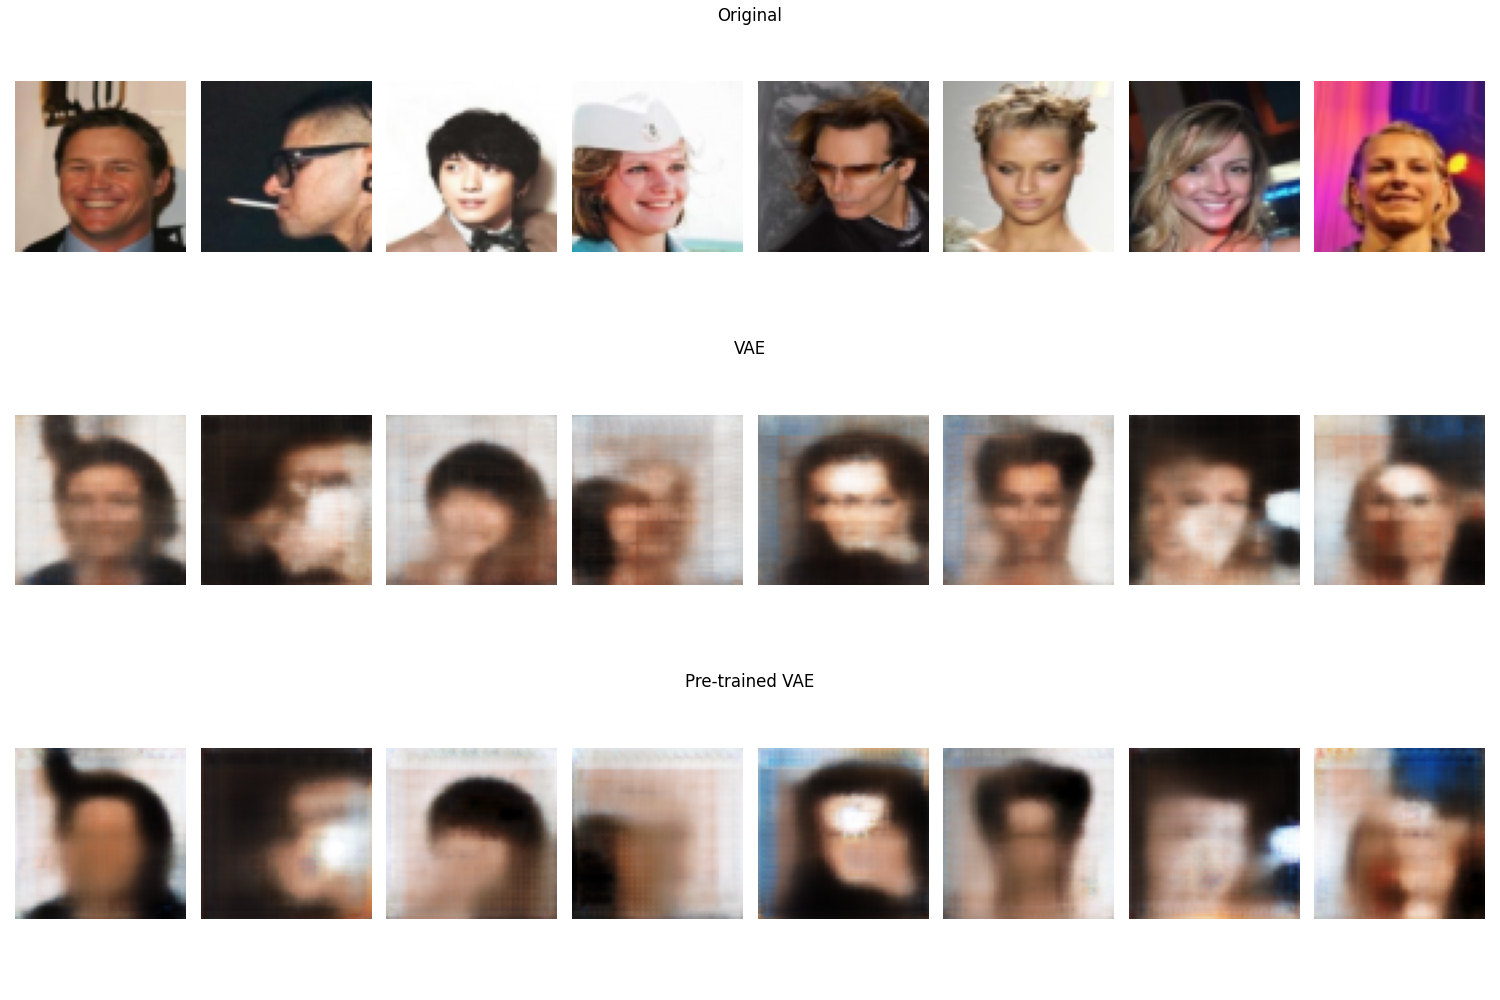

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

subfigures = fig.subfigures(3, 1)
axes = []
for i, subfig in enumerate(subfigures):
    axes.append(subfig.subplots(1,8))
# show some data
for i in range(8):
    data, _ = validation_data[i]
    with torch.no_grad():
        data = data.unsqueeze(0)
        #data_rec = model(data)
        #data_prerec = model_trained(data)
        data_rec = model.decoder(model.z_mu_transform(model.encoder(data)))
        data_prerec = model_trained.decoder(model_trained.encoder(data))

        data = data.cpu().squeeze().permute(1,2,0).numpy()
        data_rec = data_rec.cpu().squeeze().permute(1,2,0).numpy()
        data_prerec = data_prerec.cpu().squeeze().permute(1,2,0).numpy()

    axes[0][i].imshow(data)
    axes[0][i].axis("off")

    axes[1][i].imshow(data_rec)
    axes[1][i].axis("off")

    axes[2][i].imshow(data_prerec)
    axes[2][i].axis("off")

subfigures[0].suptitle("Original")
subfigures[1].suptitle("VAE")
subfigures[2].suptitle("Pre-trained VAE")
plt.tight_layout()
plt.show()


## Test...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02779026..0.034320682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015949529..0.0130450055].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039164234..0.030029386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023400642..0.023468535].


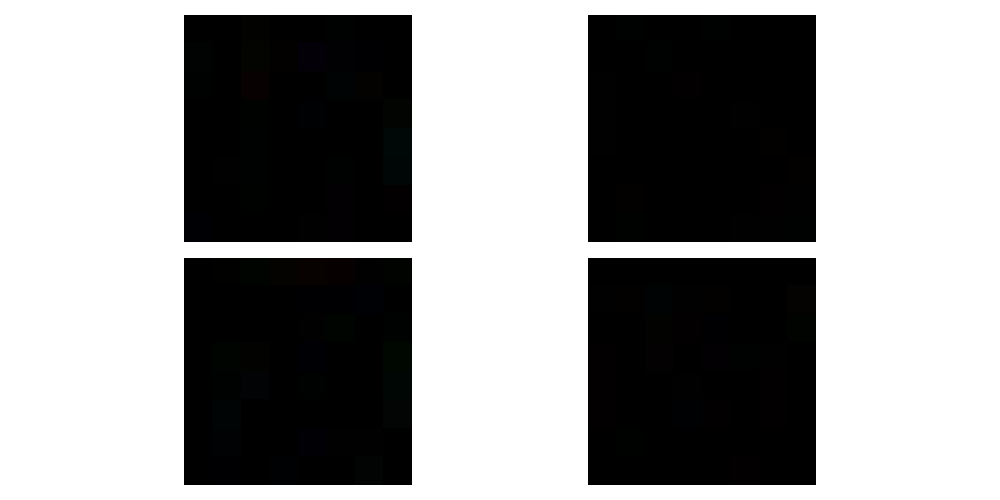

In [ ]:
data00, _ = validation_data[0]
data02, _ = validation_data[2]

model.to("cpu")
with torch.no_grad():
    data00 = data00.unsqueeze(0)
    data02 = data02.unsqueeze(0)
    z00 = model.encoder(data00)
    z02 = model.encoder(data02)

    z00_mu = model.z_mu_transform(z00)
    z00_sigma = model.z_sigma_transform(z00)
    z02_mu = model.z_mu_transform(z02)
    z02_sigma = model.z_sigma_transform(z02)

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharey=True)
ax[0,0].imshow(z00_mu.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[0,1].imshow(z00_sigma.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[0,0].axis("off")
ax[0,1].axis("off")

ax[1,0].imshow(z02_mu.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[1,1].imshow(z02_sigma.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[1,0].axis("off")
ax[1,1].axis("off")

plt.tight_layout()
plt.show()



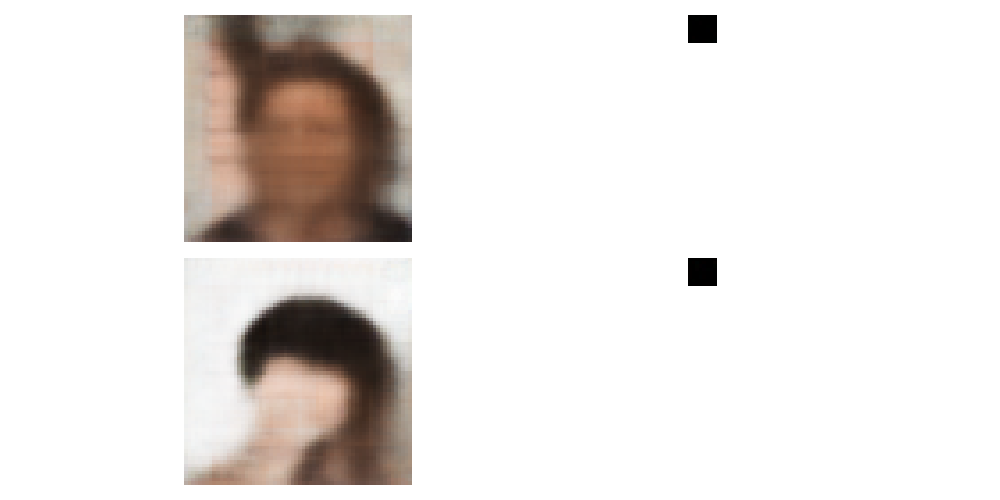

In [ ]:
with torch.no_grad():
    img1 = model.decoder(z00_mu).cpu().squeeze().permute(1,2,0).numpy()[:,:,:3]
    img2 = model.decoder(z02_mu).cpu().squeeze().permute(1,2,0).numpy()[:,:,:3]
ax[0,0].imshow(img1)
ax[0,0].axis("off")

ax[1,0].imshow(img2)
ax[1,0].axis("off")

plt.show()


In [18]:
def interpolate_vae(model, image1, image2, steps=10):
    model.eval()
    with torch.no_grad():
        # Prepare images
        image1 = image1.unsqueeze(0) if image1.dim() == 3 else image1  # [1, C, H, W]
        image2 = image2.unsqueeze(0) if image2.dim() == 3 else image2


        # Encode to latent space
        z1 = model.encoder(image1)
        z2 = model.encoder(image2)

        z1_mu = model.z_mu_transform(z1)
        z2_mu = model.z_mu_transform(z2)

        # Or if encode returns mu only:
        # z1 = model.encode(image1)
        # z2 = model.encode(image2)

        # Linear interpolation between z1 and z2
        z_interp = torch.stack([
            z1_mu * (1 - alpha) + z2_mu * alpha
            for alpha in np.arange(steps+1)/steps
        ]).squeeze()  # shape: [steps, latent_dim]

        print(np.arange(steps+1)/steps)
        print(np.array(z_interp[0] - z1_mu).sum())
        # Decode to images
        recon_images = model.decoder(z_interp)  # returns [steps, C, H, W]

        # Plot
        fig, axes = plt.subplots(1, steps+1, figsize=(steps * 2, 2))
        for i in range(steps+1):
            img = recon_images[i].cpu().permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
0.0


C:\Users\hss19\AppData\Local\Temp\ipykernel_15644\321647763.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(z_interp[0] - z1_mu).sum())


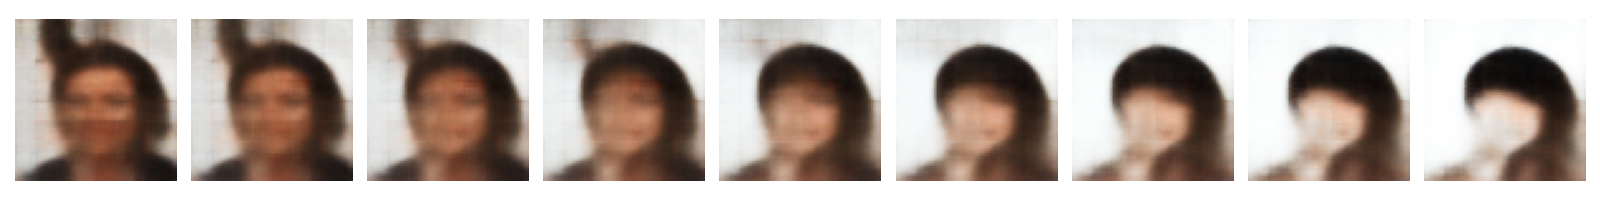

In [19]:
data00, _ = validation_data[0]
data02, _ = validation_data[2]
interpolate_vae(model, data00, data02, steps=8)

## VAE pre train

In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
import torch

# import dependencies for PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mlc.data.mnist.dataset import MNIST
from mlc.data.celeba_align.dataset import CelebaAlign
from mlc.util.model import load_checkpoint
import mlc

In [2]:
%cd C:/Users/hss19/Documents/GitHub/ml-2025

C:\Users\hss19\Documents\GitHub\ml-2025


In [3]:
dataset = CelebaAlign({"scale": 64})
train_data = dataset.get_fold("train")
validation_data = dataset.get_fold("validation")

BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True
)
validation_data_loader = torch.utils.data.DataLoader(
    validation_data, batch_size= BATCH_SIZE, num_workers=4, pin_memory=True
)

In [4]:
import argparse
from mlc.model.vae.model import VAE
# Create parser and add arguments
parser = argparse.ArgumentParser()
VAE.add_arguments(parser)

# Parse empty args to use all defaults
args = parser.parse_args([])

# Convert Namespace to dict
args_dict = vars(args)

# Instantiate model with args
model = VAE(args_dict)
model

C-VAE: init_dim=24, layer_dim=24, num_blocks=3


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True,

In [5]:
from torchsummary import summary
print(summary(model,(3,256,256),device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 256, 256]             672
              ReLU-2         [-1, 24, 256, 256]               0
       BatchNorm2d-3         [-1, 24, 256, 256]              48
            Conv2d-4         [-1, 24, 128, 128]           5,208
            Conv2d-5         [-1, 24, 128, 128]           5,208
              ReLU-6         [-1, 24, 128, 128]               0
       BatchNorm2d-7         [-1, 24, 128, 128]              48
            Conv2d-8           [-1, 24, 64, 64]           5,208
            Conv2d-9           [-1, 24, 64, 64]           5,208
             ReLU-10           [-1, 24, 64, 64]               0
      BatchNorm2d-11           [-1, 24, 64, 64]              48
           Conv2d-12           [-1, 24, 32, 32]           5,208
           Conv2d-13           [-1, 24, 32, 32]           5,208
             ReLU-14           [-1, 24,

In [ ]:
save_path = "models/cnn_autoencoder/latest/latest/model_state.pt"
#save_path = "personal/models/vae/latest/latest/model_state.pt"
state_dict = torch.load(save_path)
#state_dict
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore missing keys
#help(model.load_state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
import argparse

import nvtx
import torch
from tqdm import tqdm

from mlc.command.base import Base
from mlc.util.board import Board
from mlc.util.model import load_model_from_path, save_checkpoint, save_metadata
from mlc.util.resources import get_available_datasets, get_available_models

lr = 0.0001
personal = False
max_epochs = 50
checkpoints = 10

model.to(device)
# create optimizer
optimizer = model.get_optimizer(learning_rate= lr)

# save session metadata

save_metadata(model, dataset, use_personal_folder= personal)

# initialize tensorboard
board = Board("vae", use_personal_folder= personal, enabled= True)

# create context dict for hooks
context = {
    "model": model,
    "dataset": dataset,
    "train_data_loader": train_data_loader,
    "validation_data_loader": validation_data_loader,
    "optimizer": optimizer,
    "board": board,
    "epoch": 0,
    "device": device,
}


In [ ]:
try:  # let's catch keyboard interrupt
    pbar = tqdm(range(1, max_epochs + 1))
    pbar.set_description("Epoch")
    for epoch in pbar:
        nvtx.push_range("Epoch")
        context["epoch"] = epoch
        # call pre_epoch_hook
        model.pre_epoch_hook(context)
        # set model for training
        model.train()
        total_train_loss = 0
        pbar_train = tqdm(train_data_loader, leave=False)
        pbar_train.set_description("Train")
        nvtx.push_range("Train")
        model.pre_train_hook(context)
        for X_train, Y_train in pbar_train:
            nvtx.push_range("Batch")
            # send data to device in batches
            # this is suboptimal, we should send the whole dataset to the device if possible
            X_train, Y_train = X_train.to(device), Y_train.to(device)

            # call pre_batch_hook
            model.pre_train_batch_hook(context, X_train, Y_train)

            optimizer.zero_grad()
            Y_train_pred = model(X_train)
            train_loss = model.evaluate_loss(Y_train_pred, Y_train)
            train_loss.backward()
            optimizer.step()

            # call post_batch_hook
            model.post_train_batch_hook(context, X_train, Y_train, Y_train_pred, train_loss)
            #
            total_train_loss += train_loss.item() * len(X_train)
            #
            nvtx.pop_range()  # Batch
        # normalize loss
        total_train_loss /= len(train_data_loader.dataset)
        model.post_train_hook(context)
        nvtx.pop_range()  # Train

        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            nvtx.push_range("Validation")
            model.pre_validation_hook(context)
            pbar_validation = tqdm(validation_data_loader, leave=False)
            pbar_validation.set_description("Validation")
            for X_val, Y_val in pbar_validation:
                nvtx.push_range("Batch")
                model.pre_validation_batch_hook(context, X_train, Y_train)
                X_val, Y_val = X_val.to(device), Y_val.to(device)

                Y_val_pred = model(X_val)
                val_loss = model.evaluate_loss(Y_val_pred, Y_val)

                total_validation_loss += val_loss.item() * len(X_val)
                model.post_validation_batch_hook(context, X_val, Y_val, Y_val_pred, val_loss)
                nvtx.pop_range()  # Batch

            model.post_validation_hook(context)
            # normalize loss
            total_validation_loss /= len(validation_data_loader.dataset)
            nvtx.pop_range()  # Validation

        nvtx.pop_range()  # Epoch

        pbar.set_description(f"Epoch {epoch}, loss [t/v]: {total_train_loss:0.5f}/{total_validation_loss:0.5f}")

        # call post_epoch_hook
        model.post_epoch_hook(context)

        # save model if checkpoint or last epoch
        if (epoch % checkpoints == 0) or epoch == max_epochs:
            save_checkpoint(model, epoch, use_personal_folder = personal)

        # log to tensorboard
        board.log_scalars(
            "Curves/Loss", {"Train": total_train_loss, "Validation": total_validation_loss}, epoch
        )
        board.log_layer_gradients(model, epoch)

except KeyboardInterrupt:
    print("Training interrupted")
finally:
    board.close()

nvtx.pop_range()  # Training

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49, loss [t/v]: 209.25859/207.73673:  98%|█████████▊| 49/50 [4:07:08<04:43, 283.56s/it]  

## Code...

In [ ]:
# apply encoder to data
encoded_data = []
label = []
for i in range(len(validation_data)):
    data, _ = validation_data[i]
    data = data.unsqueeze(0)
    with torch.no_grad():
        encoded = encoder(data)
        encoded_data.append(encoded.cpu().numpy())
        label.append(validation_data.get_label(i))
encoded_data = np.concatenate(encoded_data, axis=0)
label = np.array(label)
print(encoded_data.shape)
print(label.shape)

In [ ]:
# Do PCA on encoded data
pca = PCA(n_components=2)
pca.fit(encoded_data)
encoded_data_2d = pca.transform(encoded_data)
print(encoded_data_2d.shape)

In [ ]:
# scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# scatter plot
for i in range(10):
    ax.scatter(encoded_data_2d[label == i, 0], encoded_data_2d[label == i, 1], alpha=0.5, label=f"Class {i}")
ax.legend()
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.show()

In [ ]:
# Do PCA on encoded data
pca = PCA(n_components=3)
pca.fit(encoded_data)
encoded_data_3d = pca.transform(encoded_data)
print(encoded_data_3d.shape)

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# scatter plot
for i in range(10):
    ax.scatter(
        encoded_data_3d[label == i, 0],
        encoded_data_3d[label == i, 1],
        encoded_data_3d[label == i, 2],
        alpha=0.5,
        label=f"Class {i}",
    )
ax.legend()
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

In [ ]:
# Use t-SNE to reduce the dimensionality of the data to 2D
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)
# Fit and transform the data
encoded_data_tsne = tsne.fit_transform(encoded_data)
print(encoded_data_tsne.shape)

In [ ]:
# Create a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# scatter plot
for i in range(10):
    ax.scatter(encoded_data_tsne[label == i, 0], encoded_data_tsne[label == i, 1], alpha=0.5, label=f"Class {i}")
ax.legend()
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.show()

In [ ]:
# Use t-SNE to reduce the dimensionality of the data to 3D
# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=42)
# Fit and transform the data
encoded_data_tsne_3d = tsne.fit_transform(encoded_data)
print(encoded_data_tsne_3d.shape)
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# scatter plot
for i in range(10):
    ax.scatter(
        encoded_data_tsne_3d[label == i, 0],
        encoded_data_tsne_3d[label == i, 1],
        encoded_data_tsne_3d[label == i, 2],
        alpha=0.5,
        label=f"Class {i}",
    )
ax.legend()
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()